# Non Color 3D

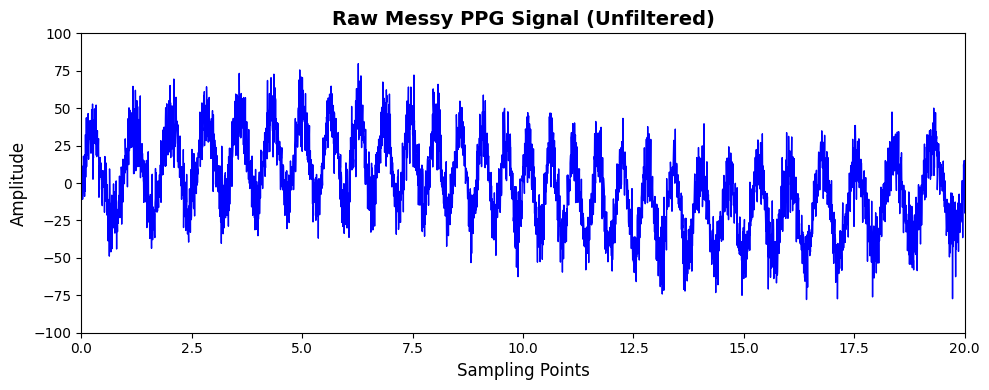

In [ ]:
import numpy as np
import plotly.graph_objs as go
import plotly.io as pio

# Optional: Force external browser rendering
pio.renderers.default = "browser"

# Create wavelength axes
x = np.linspace(400, 1100, 701)
y = np.linspace(400, 1100, 701)
X, Y = np.meshgrid(x, y)

# Initialize Z with zeros
Z = np.zeros_like(X)

# Lock random seed
np.random.seed(42)

# Create multiple random diagonal peaks
num_diag_peaks = 3
for _ in range(num_diag_peaks):
    center = np.random.uniform(400, 1100)
    peak_height = np.random.uniform(400, 200)
    sigma = np.random.uniform(30, 80)
    Z += peak_height * np.exp(-(((X - center)**2 + (Y - center)**2) / (2 * sigma**2)))

# Create small off-diagonal random bumps
num_offdiag_peaks = 20
for _ in range(num_offdiag_peaks):
    center_x = np.random.uniform(400, 1100)
    center_y = np.random.uniform(400, 1100)
    if abs(center_x - center_y) < 30:
        continue
    peak_height = np.random.uniform(20, 100)
    sigma = np.random.uniform(20, 60)
    Z += peak_height * np.exp(-(((X - center_x)**2 + (Y - center_y)**2) / (2 * sigma**2)))

# Clip any negatives
Z = np.clip(Z, 0, None)

# Define plane region and height
plane_x_min = 750
plane_x_max = 875
plane_y_min = 750
plane_y_max = 875
plane_z = 250

# Mask for points within the plane region AND above plane_z
mask_red = (
    (X >= plane_x_min) & (X <= plane_x_max) &
    (Y >= plane_y_min) & (Y <= plane_y_max) &
    (Z >= plane_z)
)

# Diagnostics: how many points satisfy this?
print("Number of red points:", np.sum(mask_red))

# Also check the max Z in the box to confirm
in_box = (
    (X >= plane_x_min) & (X <= plane_x_max) &
    (Y >= plane_y_min) & (Y <= plane_y_max)
)
print("Max Z in box:", np.max(Z[in_box]))

# Original surface
surface_original = go.Surface(
    x=X,
    y=Y,
    z=Z,
    colorscale='Viridis',
    cmin=0,
    cmax=700,
    showscale=False,
    opacity=1
)

# Compute normalized Z in the masked region
Z_in_mask = Z[mask_red]
if len(Z_in_mask) > 0:
    min_z = np.min(Z_in_mask)
    max_z = np.max(Z_in_mask)
    norm_Z = (Z - min_z) / (max_z - min_z + 1e-9)
    norm_Z = np.clip(norm_Z, 0, 1)
else:
    norm_Z = np.zeros_like(Z)

# Prepare surface with gradient colors
Z_gradient = np.where(mask_red, Z, np.nan)
norm_Z_gradient = np.where(mask_red, norm_Z, np.nan)

surface_gradient = go.Surface(
    x=X,
    y=Y,
    z=Z_gradient,
    surfacecolor=norm_Z_gradient,  # Use normalized Z to drive color
    colorscale=[
        [0.0, 'yellow'],
        [1.0, 'red']
    ],
    showscale=False,
    opacity=1
)

# Plane at Z=300
Z_plane = np.full_like(Z, plane_z)
Z_plane = np.where(
    (X >= plane_x_min) & (X <= plane_x_max) &
    (Y >= plane_y_min) & (Y <= plane_y_max),
    Z_plane,
    np.nan
)

surface_plane = go.Surface(
    x=X,
    y=Y,
    z=Z_plane,
    colorscale=[[0, 'skyblue'], [1, 'skyblue']],
    showscale=False,
    opacity=0.5
)

# Create text marker at (820,820) with z~400
x_coord = 820
y_coord = 820
z_text = 380

text_marker = go.Scatter3d(
    x=[x_coord],
    y=[y_coord],
    z=[z_text + 15],  # offset above the surface
    mode='text',
    text=(f"Wavelength 515 nm"),
    textposition="top center",
    textfont=dict(color='green', size=20)
)

layout = go.Layout(
    title='Simulated 3D Mountain with Red Highlight Above Plane Z=300',
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False),
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.2))
    ),
    autosize=True,
    margin=dict(l=0, r=0, b=0, t=0)
)

# Important: draw red surface last so it is on top
fig = go.Figure(
    data=[surface_original, surface_plane, surface_gradient, text_marker],
    layout=layout
)
fig.show()


# Colorful 3D

In [7]:
import numpy as np
import plotly.graph_objs as go
import plotly.io as pio

pio.renderers.default = "browser"

# Create wavelength axes
x = np.linspace(400, 1100, 701)
y = np.linspace(400, 1100, 701)
X, Y = np.meshgrid(x, y)

Z = np.zeros_like(X)

np.random.seed(42)

# Diagonal peaks
num_diag_peaks = 3
for _ in range(num_diag_peaks):
    center = np.random.uniform(400, 1100)
    peak_height = np.random.uniform(400, 200)
    sigma = np.random.uniform(30, 80)
    Z += peak_height * np.exp(-(((X - center)**2 + (Y - center)**2) / (2 * sigma**2)))

# Off-diagonal bumps
num_offdiag_peaks = 20
for _ in range(num_offdiag_peaks):
    center_x = np.random.uniform(400, 1100)
    center_y = np.random.uniform(400, 1100)
    if abs(center_x - center_y) < 30:
        continue
    peak_height = np.random.uniform(20, 100)
    sigma = np.random.uniform(20, 60)
    Z += peak_height * np.exp(-(((X - center_x)**2 + (Y - center_y)**2) / (2 * sigma**2)))

Z = np.clip(Z, 0, None)

plane_x_min = 750
plane_x_max = 875
plane_y_min = 750
plane_y_max = 875
plane_z = 250

# Normalize X over 400–1100
norm_x = (X - 400) / (1100 - 400)
norm_x = np.clip(norm_x, 0, 1)

# Colorscale: 0–0.43 is visible spectrum, >0.43 is black
colorscale_full = [
    [0.0, 'indigo'],
    [0.15, 'blue'],
    [0.3, 'cyan'],
    [0.5, 'green'],
    [0.65, 'yellow'],
    [0.85, 'red'],
    [0.86, 'black'],
    [1.0, 'black']
]

# Main surface colored by wavelength
surface_wavelength = go.Surface(
    x=X,
    y=Y,
    z=Z,
    surfacecolor=norm_x,
    colorscale=colorscale_full,
    cmin=0,
    cmax=1,
    showscale=False,
    opacity=1
)

# Plane
Z_plane = np.full_like(Z, plane_z)
Z_plane = np.where(
    (X >= plane_x_min) & (X <= plane_x_max) &
    (Y >= plane_y_min) & (Y <= plane_y_max),
    Z_plane,
    np.nan
)

surface_plane = go.Surface(
    x=X,
    y=Y,
    z=Z_plane,
    colorscale=[[0, 'skyblue'], [1, 'skyblue']],
    showscale=False,
    opacity=0.5
)

layout = go.Layout(
    title='Spectrometer Response with Extended Wavelength Colors',
    scene=dict(
        xaxis=dict(
            visible=False,
            showgrid=False,
            zeroline=False,
            showticklabels=False
        ),
        yaxis=dict(
            visible=False,
            showgrid=False,
            zeroline=False,
            showticklabels=False
        ),
        zaxis=dict(
            visible=False,
            showgrid=False,
            zeroline=False,
            showticklabels=False
        ),
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.2))
    ),
    autosize=True,
    margin=dict(l=0, r=0, b=0, t=0)
)

fig = go.Figure(
    data=[
        surface_wavelength,
        surface_plane
    ],
    layout=layout
)

fig.show()


# Raw PPG Signal

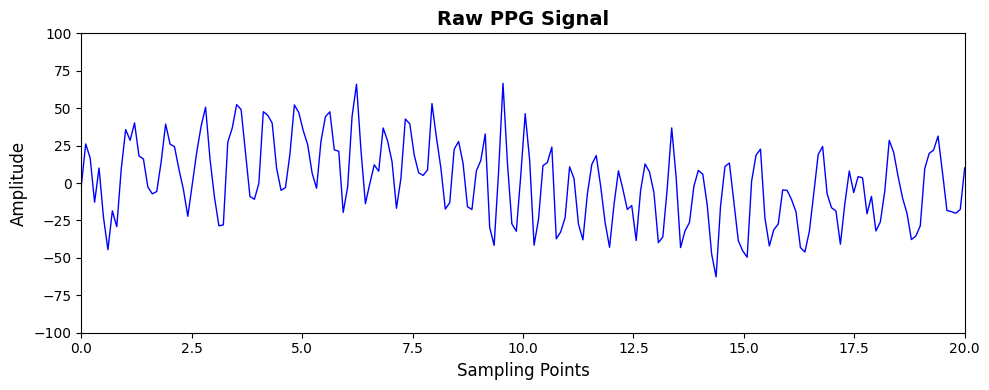

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
duration_seconds = 20
sampling_rate = 10
time = np.linspace(0, duration_seconds, duration_seconds * sampling_rate)

# Generate heart rate profile: 60 bpm -> 120 bpm -> 60 bpm
half_len = len(time) // 2
hr_ramp_up = np.linspace(60, 120, half_len)
hr_ramp_down = np.linspace(120, 60, len(time) - half_len)
heart_rate_bpm = np.concatenate((hr_ramp_up, hr_ramp_down))
heart_rate_hz = heart_rate_bpm / 60

# Simulate clean sine wave
ppg_signal = np.zeros_like(time)
phase = 0
for i in range(len(time)):
    freq = heart_rate_hz[i]
    phase += 2 * np.pi * freq / sampling_rate
    # Random amplitude modulation (0.5x - 1.5x)
    amplitude_mod = 30 * np.random.uniform(0.5, 1.5)
    ppg_signal[i] = amplitude_mod * np.sin(phase)

# Add baseline wander (low-frequency noise)
baseline_wander = 20 * np.sin(2 * np.pi * 0.05 * time)  # very slow drift

# Add high-frequency noise
high_freq_noise = np.random.normal(0, 10, len(time))

# Combine all
messy_ppg = ppg_signal + baseline_wander + high_freq_noise

# Plot
plt.figure(figsize=(10, 4))
plt.plot(time, messy_ppg, color='blue', linewidth=1)
plt.title('Raw PPG Signal', fontsize=14, fontweight='bold')
plt.xlabel('Sampling Points', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.xlim(time[0], time[-1])
plt.ylim(-100, 100)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.box(True)
plt.tight_layout()
plt.show()


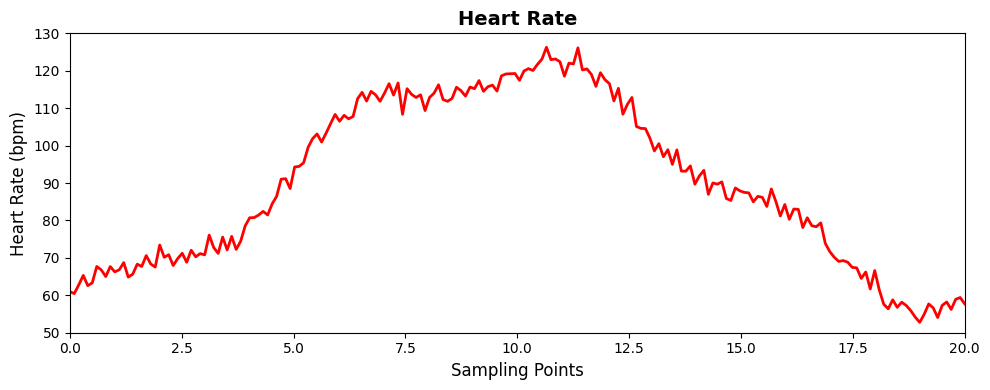

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
duration_seconds = 20
sampling_rate = 10
time = np.linspace(0, duration_seconds, duration_seconds * sampling_rate)

half_len = len(time) // 2

# Use sine easing for smooth ramp up/down
ramp_up = 60 + (120 - 60) * 0.5 * (1 - np.cos(np.linspace(0, np.pi, half_len)))
ramp_down = 120 - (120 - 60) * 0.5 * (1 - np.cos(np.linspace(0, np.pi, len(time) - half_len)))

base_hr = np.concatenate((ramp_up, ramp_down))

# Add large oscillations (simulate respiration sinus arrhythmia)
oscillation = 5 * np.sin(2 * np.pi * 0.2 * time) + 3 * np.sin(2 * np.pi * 0.05 * time)

# Add larger random jitter
np.random.seed(42)
jitter = np.random.normal(0, 2, len(time))

# Combine all
heart_rate_bpm = base_hr + oscillation + jitter

# Plot heart rate curve
plt.figure(figsize=(10, 4))
plt.plot(time, heart_rate_bpm, color='red', linewidth=2)
plt.title('Heart Rate', fontsize=14, fontweight='bold')
plt.xlabel('Sampling Points', fontsize=12)
plt.ylabel('Heart Rate (bpm)', fontsize=12)
plt.xlim(time[0], time[-1])
plt.ylim(50, 130)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.box(True)
plt.tight_layout()
plt.show()
